In [21]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")


# one df per dataset
# df_cifar10 <- df[df$dataset == "cifar10",]
# df_cifar100 <- df[df$dataset == "cifar100",]
# df_imagenette <- df[df$dataset == "imagenette",]

df <- df[df$dataset == "imagenette",]

print(names(df))

  [1] "dataset"                                
  [2] "fgsm_20_ensemble_acc"                   
  [3] "fgsm_20_layer_accs.20"                  
  [4] "fgsm_20_layer_accs.30"                  
  [5] "fgsm_20_layer_accs.35"                  
  [6] "fgsm_20_layer_accs.40"                  
  [7] "fgsm_20_layer_accs.45"                  
  [8] "fgsm_20_layer_accs.50"                  
  [9] "fgsm_20_layer_accs.52"                  
 [10] "fgsm_30_ensemble_acc"                   
 [11] "fgsm_30_layer_accs.20"                  
 [12] "fgsm_30_layer_accs.30"                  
 [13] "fgsm_30_layer_accs.35"                  
 [14] "fgsm_30_layer_accs.40"                  
 [15] "fgsm_30_layer_accs.45"                  
 [16] "fgsm_30_layer_accs.50"                  
 [17] "fgsm_30_layer_accs.52"                  
 [18] "fgsm_35_ensemble_acc"                   
 [19] "fgsm_35_layer_accs.20"                  
 [20] "fgsm_35_layer_accs.30"                  
 [21] "fgsm_35_layer_accs.35"           

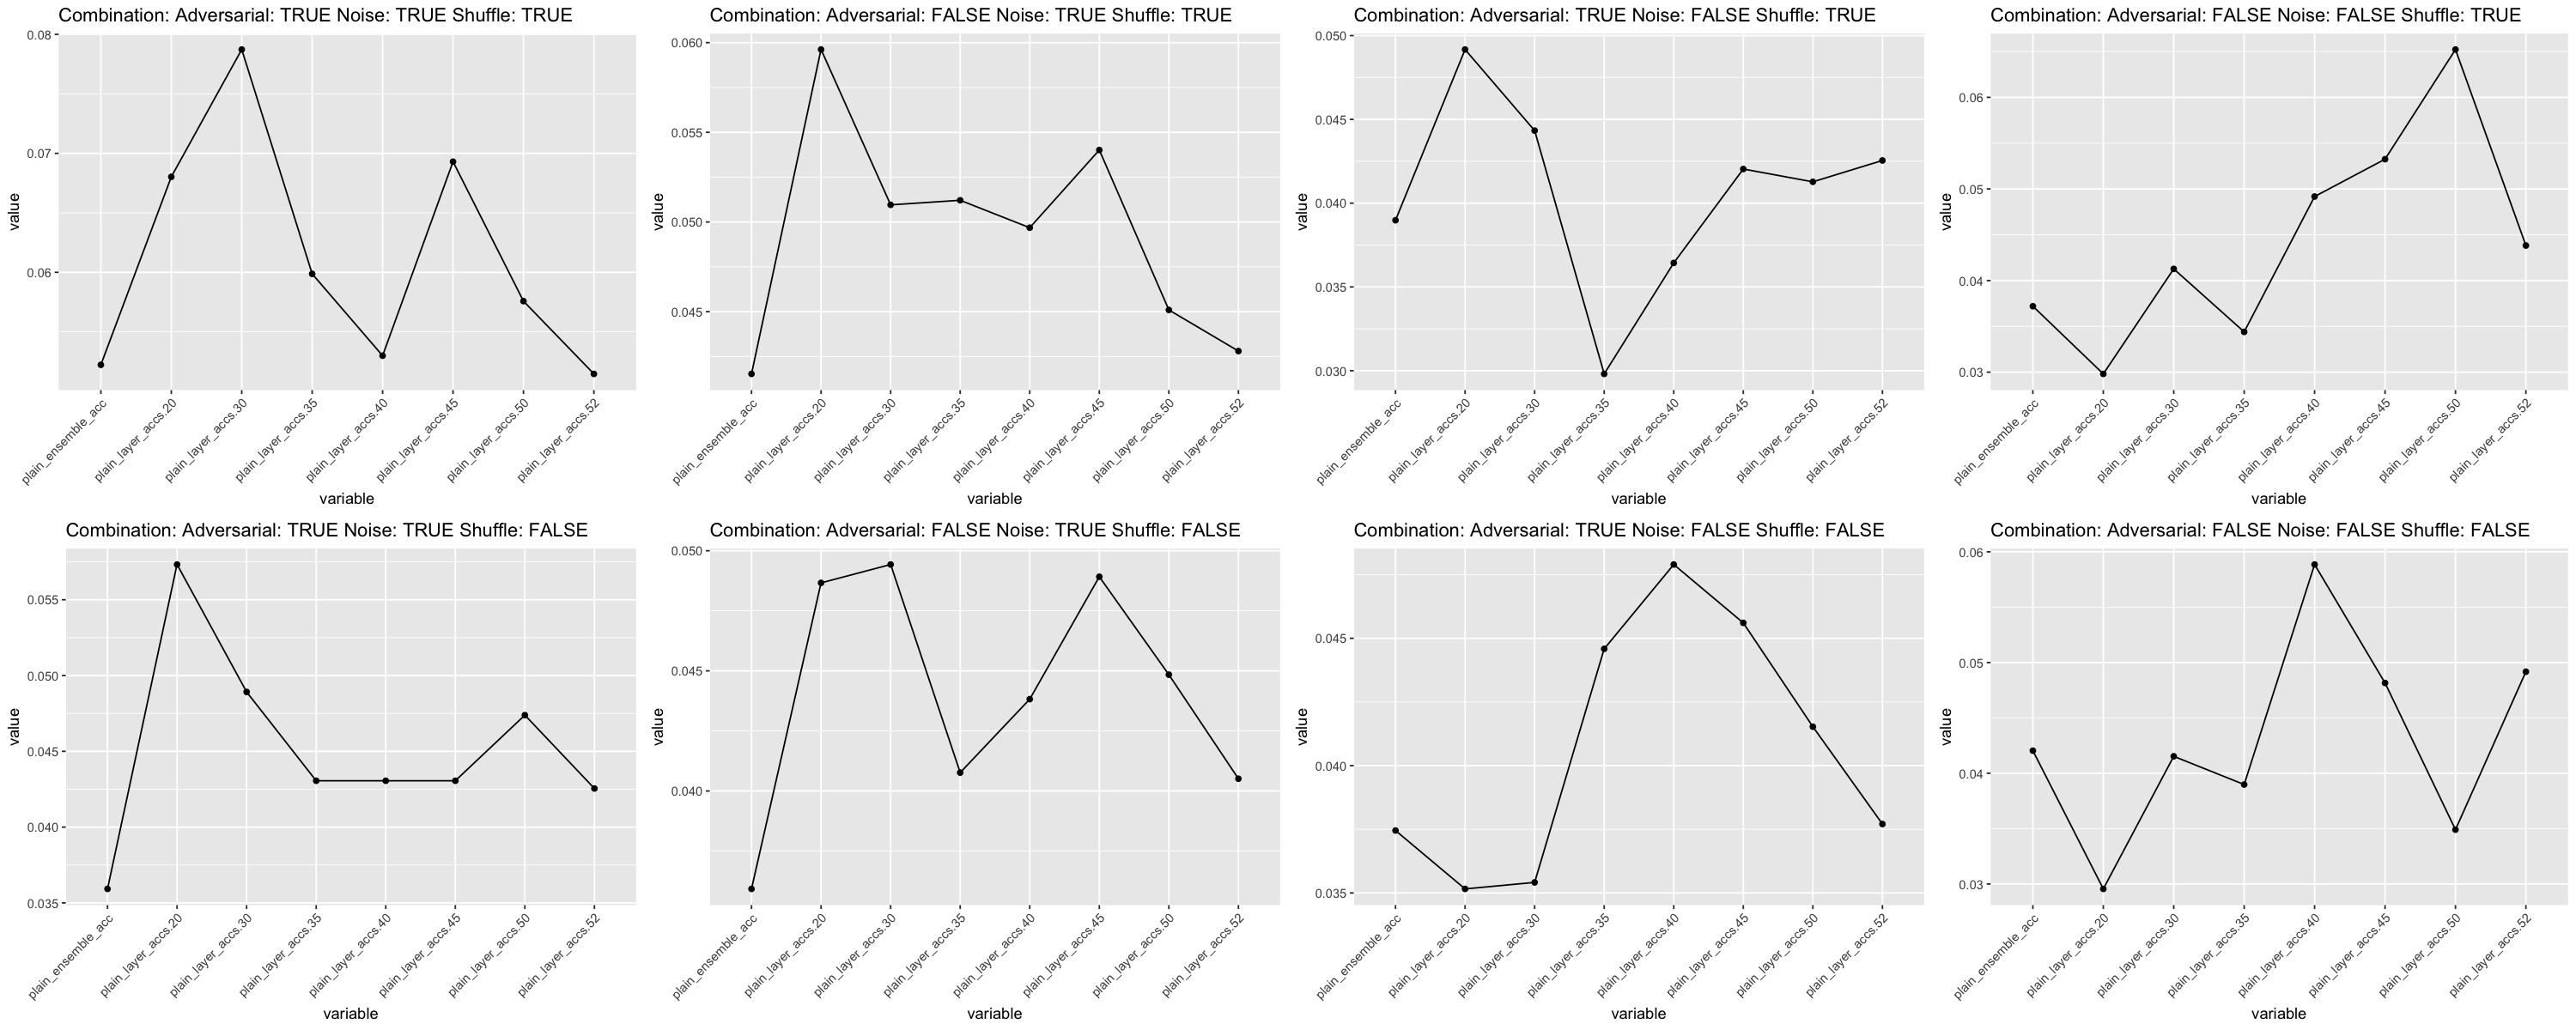

In [28]:
combs <- expand.grid(
  training_adversarial = c(TRUE, FALSE),
  training_noise = c(TRUE, FALSE),
  training_shuffle = c(TRUE, FALSE)
)

acc_cols <- c("plain_ensemble_acc", "plain_layer_accs.20", "plain_layer_accs.30", 
             "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", 
             "plain_layer_accs.50", "plain_layer_accs.52")


options(repr.plot.width=25, repr.plot.height=10)

plots <- list()

for (i in 1:nrow(combs)) {
    filtered_df <- df[df$training_adversarial == combs$training_adversarial[i] &
                   df$training_noise == combs$training_noise[i] &
                   df$training_shuffle == combs$training_shuffle[i], ]
  
    melted_df <- melt(filtered_df, measure.vars = acc_cols)
  
    p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
        geom_line() +
        geom_point() +
        ggtitle(paste("Combination:",
                    "Adversarial:", combs$training_adversarial[i],
                    "Noise:", combs$training_noise[i],
                    "Shuffle:", combs$training_shuffle[i])) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    plots[[i]] <- p
}

do.call(grid.arrange, c(plots, ncol = 4))
